In [16]:
import csv
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt  
from ipywidgets import interact, FloatSlider
from datetime import datetime
import pandas as pd
import os

In [17]:
# Préparation des dataframes des séries temporelles
Data_file = "data/Data/S1A_ASC-DSC_VV-VH_Paracou"

df_VH_ASC_TropiScat = pd.read_csv(f"{Data_file}/s1a_vh_ASC_047_TropiScat.csv")
df_VH_DSC_TropiScat =  pd.read_csv(f"{Data_file}/s1a_vh_DSC_039_TropiScat.csv")
df_VV_ASC_TropiScat =  pd.read_csv(f"{Data_file}/s1a_vv_ASC_047_TropiScat.csv")
df_VV_DSC_TropiScat =  pd.read_csv(f"{Data_file}/s1a_vv_DSC_039_TropiScat.csv")

dfs_TropiScat = {
    "VV_ASC": df_VV_ASC_TropiScat,
    "VH_ASC": df_VH_ASC_TropiScat,
    "VV_DSC": df_VV_DSC_TropiScat,
    "VH_DSC": df_VH_DSC_TropiScat,
}
df_VH_ASC_allROI =  pd.read_csv(f"{Data_file}/s1a_vh_ASC_047_allROI.csv")
df_VH_DSC_allROI =  pd.read_csv(f"{Data_file}/s1a_vh_DSC_039_allROI.csv")
df_VV_ASC_allROI =  pd.read_csv(f"{Data_file}/s1a_vv_ASC_047_allROI.csv")
df_VV_DSC_allROI =  pd.read_csv(f"{Data_file}/s1a_vv_DSC_039_allROI.csv")

dfs_allROI = {
    "VV_ASC": df_VV_ASC_allROI,
    "VH_ASC": df_VH_ASC_allROI,
    "VV_DSC": df_VV_DSC_allROI,
    "VH_DSC": df_VH_DSC_allROI,
}


value_TropiScat= {
    "VV_ASC": df_VV_ASC_TropiScat.select_dtypes(include='number').to_numpy(),
    "VH_ASC": df_VH_ASC_TropiScat.select_dtypes(include='number').to_numpy(),
    "VV_DSC": df_VV_DSC_TropiScat.select_dtypes(include='number').to_numpy(),
    "VH_DSC": df_VH_DSC_TropiScat.select_dtypes(include='number').to_numpy(),
}

value_allROI = {
    "VV_ASC": df_VV_ASC_allROI.select_dtypes(include='number').to_numpy(),
    "VH_ASC": df_VH_ASC_allROI.select_dtypes(include='number').to_numpy(),
    "VV_DSC": df_VV_DSC_allROI.select_dtypes(include='number').to_numpy(),
    "VH_DSC": df_VH_DSC_allROI.select_dtypes(include='number').to_numpy(),
}

date_TropiScat= {
    "VV_ASC": np.array(df_VV_ASC_TropiScat)[:,0],
    "VH_ASC": np.array(df_VH_ASC_TropiScat)[:,0],
    "VV_DSC": np.array(df_VV_DSC_TropiScat)[:,0],
    "VH_DSC": np.array(df_VH_DSC_TropiScat)[:,0],
}
date_allROI= {
    "VV_ASC": np.array(df_VV_ASC_allROI)[:,0],
    "VH_ASC": np.array(df_VH_ASC_allROI)[:,0],
    "VV_DSC": np.array(df_VV_DSC_allROI)[:,0],
    "VH_DSC": np.array(df_VH_DSC_allROI)[:,0],
}

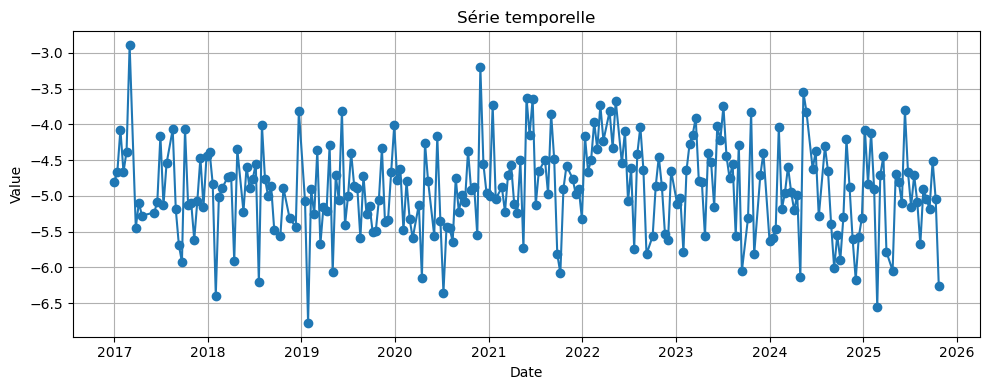

In [18]:

# La série temporelle
T=date_TropiScat['VV_ASC']
dates= [datetime.strptime(t, "%Y-%m-%d") for t in T]
days = np.array([(d - dates[0]).days for d in dates])
intervals=np.diff(days)
fs=1/np.mean(intervals)

values=value_TropiScat['VV_ASC']

plt.figure(figsize=(10,4))
plt.plot(dates, values, marker='o')
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Série temporelle")
plt.grid(True)

plt.tight_layout()
plt.show()  

In [34]:
def get_top_periods(freqs, psd, n_peaks=2):
    peak_indices = np.argsort(psd)[::-1][:n_peaks]
    top_freqs = freqs[peak_indices]  # en cycles/jour
    top_periods = [1/f for f in top_freqs if f > 0]  # en jours
    return [round(p) for p in top_periods], top_freqs, psd[peak_indices]

def psd_welch_annee(df, nom, window_lengths=[730, 900, 1000], overlap_ratios=[0.30, 0.40, 0.50], n_peaks=3, outdir="figures_welch", prefix="PSD", show=True):
    df = df[nom]
    y = df[:,0]
    fs = 1/12
    os.makedirs(outdir, exist_ok=True)

    for ol in overlap_ratios:
        fig, ax = plt.subplots(figsize=(10, 6))
        print(f"\n===== Overlap Analysis = {ol*100:.0f}% =====")

        for i, wl in enumerate(window_lengths):
            wl_samples = int(np.floor(wl / 12))
            nperseg = min(wl_samples, len(y))
            noverlap = int(nperseg * ol)
            freqs, psd = signal.welch(y, fs=fs, nperseg=nperseg, noverlap=noverlap)
            freqs_annee = freqs * 365
            mask = (freqs_annee > 0.1) & (freqs_annee < 10)

            line, = ax.semilogx(freqs_annee[mask], psd[mask], label=f'Window: {wl} days')
            color = line.get_color()

            top_periods, top_freqs, top_psds = get_top_periods(freqs[mask], psd[mask], n_peaks=n_peaks)
            top_freqs_annee = top_freqs * 365

            # Points sur les pics
            ax.scatter(top_freqs_annee, top_psds, color=color, s=80, zorder=5)
            # Annotations
            for f_ann, p_ann, period in zip(top_freqs_annee, top_psds, top_periods):
                ax.annotate(f"{period}d", xy=(f_ann, p_ann),
                            xytext=(5, 5), textcoords="offset points",
                            fontsize=7, color=color)

            top_periods_years = [p/365 for p in top_periods]
            print(f" WL = {wl} days — Dominant periods ≈ "
                  f"{[round(period,3) for period in top_periods_years]} years"
                  f" or, {top_periods} days")

        ax.set_title(f"DSP Welch, Overlap {ol*100:.0f}%")
        ax.set_xlabel("Frequency (cycles/year) [log]")
        ax.set_ylabel("Power Spectral Density")
        ax.tick_params(axis='both', which='major')
        ax.grid(True)
        ax.legend()
        plt.tight_layout()

        fname = f"{prefix}_overlap_{int(ol*100)}pct_{nom}.png"
        fpath = os.path.join(outdir, fname)
        plt.savefig(fpath, dpi=300, bbox_inches="tight")
        print(f"✔ Figure sauvegardée : {fpath}")
        if show:
            plt.show()
        else:
            plt.close()


===== Overlap Analysis = 70% =====
 WL = 730 days — Dominant periods ≈ [0.493, 0.986, 0.658] years or, [180, 360, 240] days
 WL = 910 days — Dominant periods ≈ [0.493, 0.822, 0.411] years or, [180, 300, 150] days
 WL = 1095 days — Dominant periods ≈ [0.499, 0.427, 0.997] years or, [182, 156, 364] days
 WL = 1280 days — Dominant periods ≈ [0.436, 0.499, 0.871] years or, [159, 182, 318] days
 WL = 1460 days — Dominant periods ≈ [0.441, 0.499, 3.978] years or, [161, 182, 1452] days
✔ Figure sauvegardée : figures_welch\PSD_overlap_70pct_VH_DSC.png


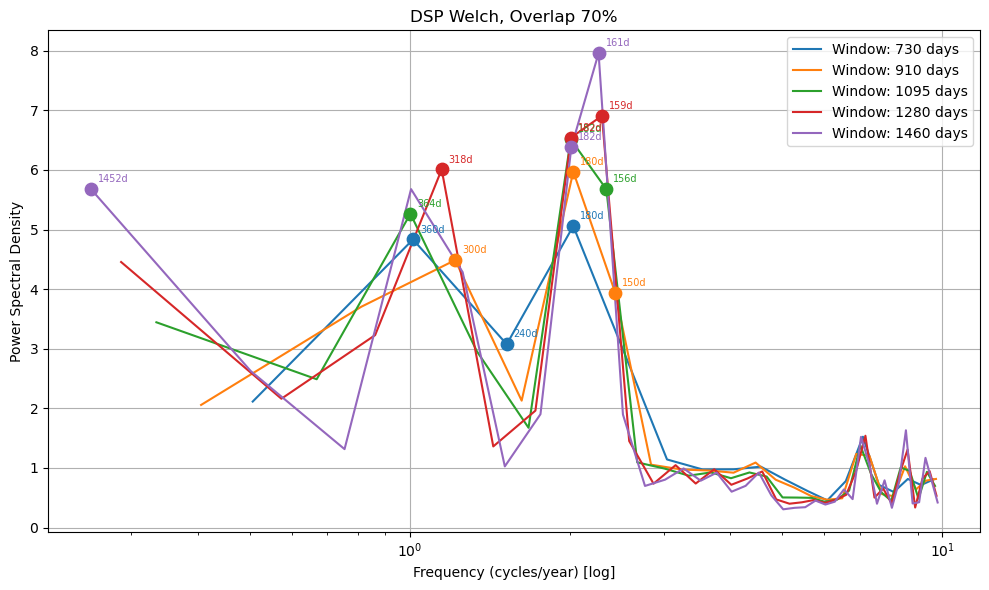


===== Overlap Analysis = 80% =====
 WL = 730 days — Dominant periods ≈ [0.493, 0.986, 0.658] years or, [180, 360, 240] days
 WL = 910 days — Dominant periods ≈ [0.493, 0.822, 0.411] years or, [180, 300, 150] days
 WL = 1095 days — Dominant periods ≈ [0.499, 0.997, 0.427] years or, [182, 364, 156] days
 WL = 1280 days — Dominant periods ≈ [0.436, 0.499, 0.871] years or, [159, 182, 318] days
 WL = 1460 days — Dominant periods ≈ [0.441, 0.499, 0.995] years or, [161, 182, 363] days
✔ Figure sauvegardée : figures_welch\PSD_overlap_80pct_VH_DSC.png


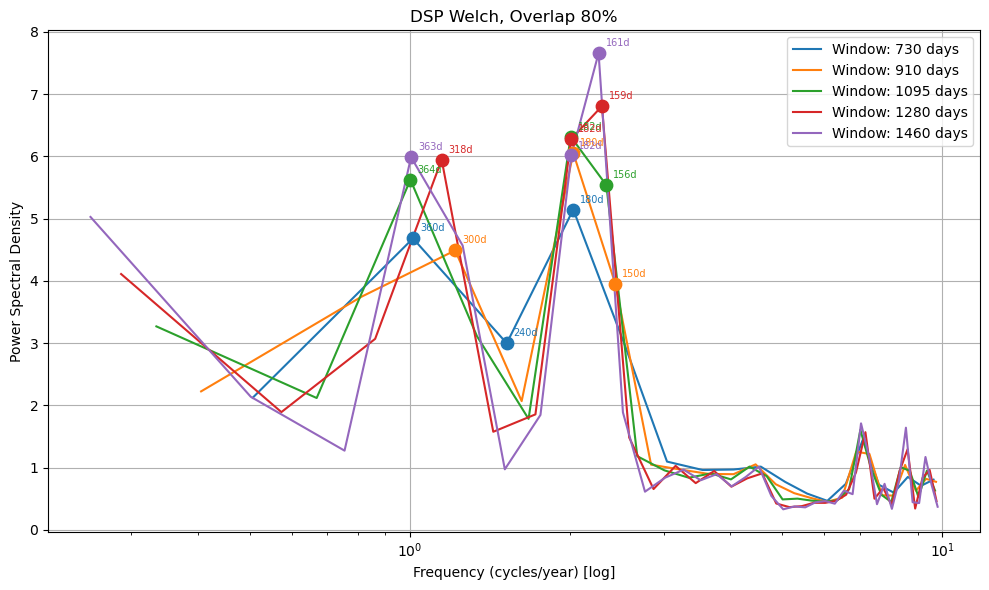


===== Overlap Analysis = 90% =====
 WL = 730 days — Dominant periods ≈ [0.493, 0.986, 0.658] years or, [180, 360, 240] days
 WL = 910 days — Dominant periods ≈ [0.493, 0.822, 0.411] years or, [180, 300, 150] days
 WL = 1095 days — Dominant periods ≈ [0.499, 0.427, 0.997] years or, [182, 156, 364] days
 WL = 1280 days — Dominant periods ≈ [0.436, 0.499, 0.871] years or, [159, 182, 318] days
 WL = 1460 days — Dominant periods ≈ [0.441, 0.499, 0.995] years or, [161, 182, 363] days
✔ Figure sauvegardée : figures_welch\PSD_overlap_90pct_VH_DSC.png


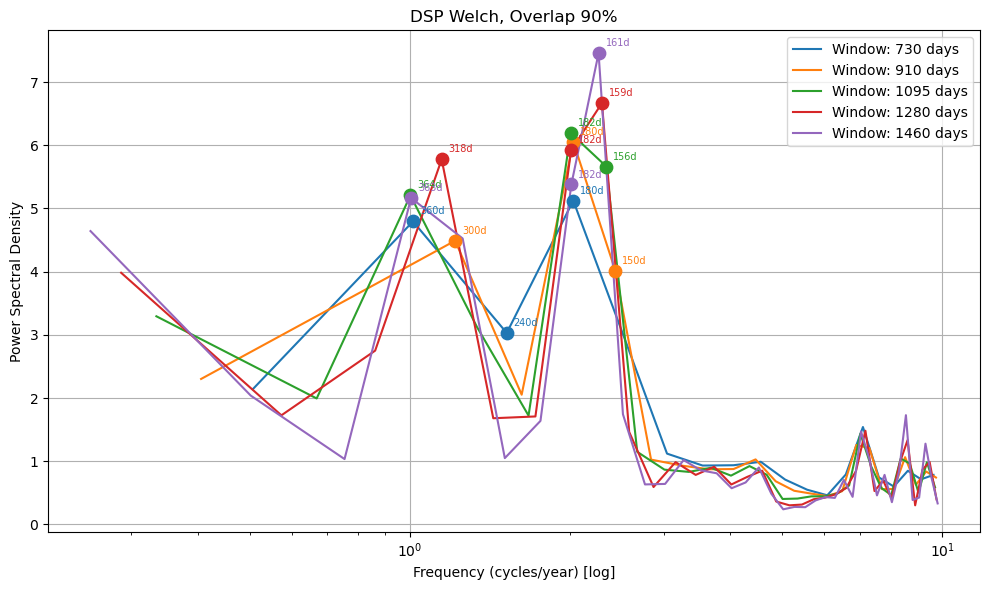

In [36]:
psd_welch_annee(value_allROI, "VH_DSC", window_lengths=[730, 910, 1095, 1280, 1460], overlap_ratios=[0.70,0.80,0.90], n_peaks=3, outdir="figures_welch", prefix="PSD", show=True)
# 300 jours → fréquence = 365/300 ≈ 1.22 cycles/an (à gauche)
# 180 jours → fréquence = 365/180 ≈ 2.03 cycles/an (à droite)

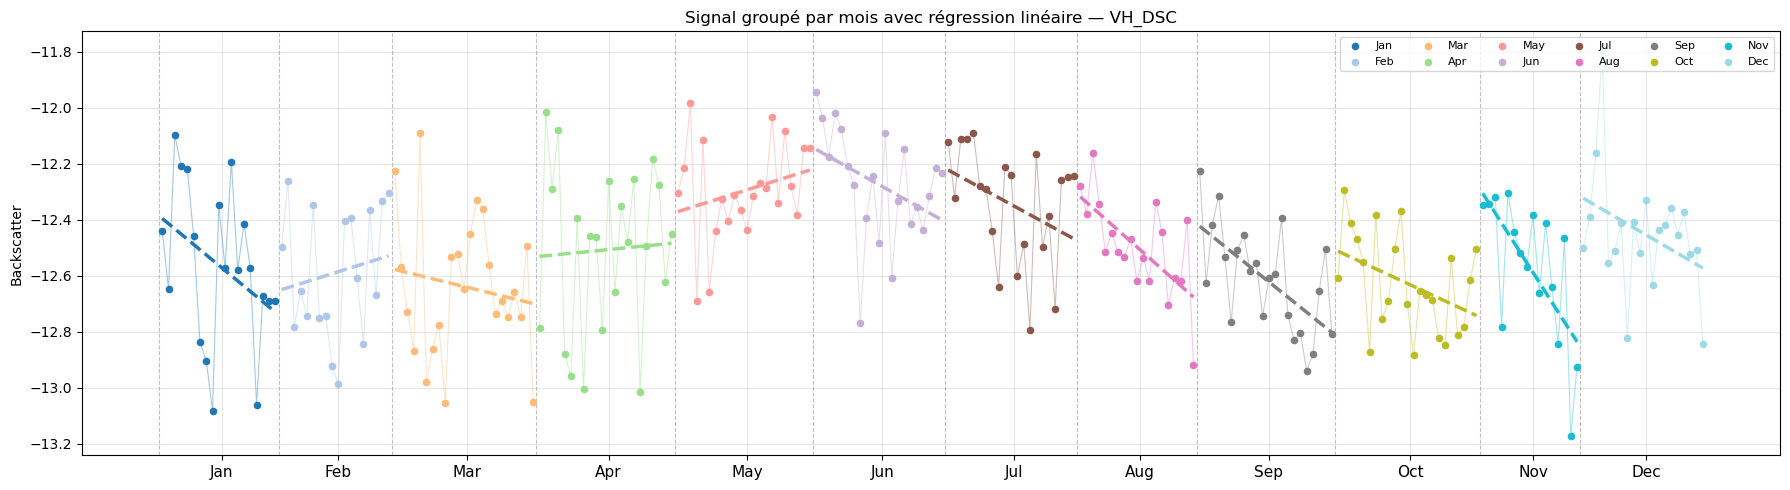

In [10]:
def plot_signal_par_mois_single(df, dates_dict, nom, title=None):
    """
    Trace le signal en concaténant les mois sur l'axe X :
    d'abord tous les janvier (triés par année), puis tous les février, etc.
    Avec une régression linéaire par mois.
    """
    values = df[nom][:, 0]
    dates_raw = [datetime.strptime(t, "%Y-%m-%d") for t in dates_dict[nom]]
    
    df_plot = pd.DataFrame({
        "date": dates_raw,
        "value": values,
        "month": [d.month for d in dates_raw],
        "year": [d.year for d in dates_raw],
    }).sort_values(["month", "date"]).reset_index(drop=True)
    
    mois_labels = ["Jan","Feb","Mar","Apr","May","Jun",
                   "Jul","Aug","Sep","Oct","Nov","Dec"]
    colors = plt.cm.tab20(np.linspace(0, 1, 12))
    
    fig, ax = plt.subplots(figsize=(18, 5))
    
    x_cursor = 0
    xticks_pos, xticks_labels = [], []
    
    for m in range(1, 13):
        df_month = df_plot[df_plot["month"] == m].copy()
        if df_month.empty:
            continue
        
        n_pts = len(df_month)
        x_local = np.arange(x_cursor, x_cursor + n_pts)
        y = df_month["value"].values
        
        # Plot points
        ax.scatter(x_local, y, color=colors[m-1], s=20, zorder=3, label=mois_labels[m-1])
        ax.plot(x_local, y, color=colors[m-1], alpha=0.4, linewidth=0.8)
        
        # Régression linéaire
        coeffs = np.polyfit(x_local, y, 1)
        reg_line = np.polyval(coeffs, x_local)
        ax.plot(x_local, reg_line, color=colors[m-1], linewidth=2.5, linestyle="--", zorder=4)
        
        # Séparateur et label
        ax.axvline(x_cursor - 0.5, color="gray", linewidth=0.8, linestyle="--", alpha=0.5)
        xticks_pos.append(x_cursor + n_pts / 2)
        xticks_labels.append(mois_labels[m-1])
        
        x_cursor += n_pts
    
    ax.set_xticks(xticks_pos)
    ax.set_xticklabels(xticks_labels, fontsize=11)
    ax.set_ylabel("Backscatter")
    ax.set_title(title or f"Signal groupé par mois avec régression linéaire — {nom}")
    ax.legend(loc="upper right", ncol=6, fontsize=8)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_signal_par_mois_single(value_allROI, date_allROI, "VH_DSC")